## Introduction to the dataset

- World Health Organization has  estimated 12 million deaths occur worldwide, every year due to Heart diseases.

- Half the deaths in the United States and other developed countries are due to cardio vascular diseases. 

- The early prognosis of cardiovascular diseases can aid in making decisions on lifestyle changes in high risk patients and in turn reduce the complications.

- This research intends to pinpoint the most relevant/risk factors of heart disease as well as predict the overall risk using logistic regression.


In [1]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, mean_squared_error
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, Binarizer
sc = StandardScaler()
le = LabelEncoder()

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
rfr = RandomForestRegressor()
rfc = RandomForestClassifier()
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Test
dfp = pd.read_csv('US_Heart_Patients.csv')
dfp.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [3]:
dfp.shape

(4240, 16)

In [4]:
target_var = 'TenYearCHD'

In [5]:
def split_data(df, y = target_var):
    x = df.loc[:, df.columns != y]
    y = df.loc[:, y]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 123)
    # x_train, x_val, y_train, y_val =  train_test_split(x_train, y_train, test_size = 0.2, random_state = 123)

    return x_train, x_test, y_train, y_test

In [6]:
def get_acc(model, x, y, type_of_y):
    pred_acc = model.predict(x)
    if type_of_y in ['float', 'int']:
        return math.sqrt(mean_squared_error(pred_acc, y))
    elif type_of_y == 'category':
        return accuracy_score(y, pred_acc)
    else:
        print("No Accuracy")

###  EDA and Feature Engineering

#### Univariate Analysis

In [7]:
# Caonverting object and numerical to category

to_be_cat = ['male', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'TenYearCHD']
dfp[to_be_cat]= dfp[to_be_cat].astype('category')
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   male             4240 non-null   category
 1   age              4240 non-null   int64   
 2   education        4135 non-null   category
 3   currentSmoker    4240 non-null   category
 4   cigsPerDay       4211 non-null   float64 
 5   BPMeds           4187 non-null   category
 6   prevalentStroke  4240 non-null   category
 7   prevalentHyp     4240 non-null   category
 8   diabetes         4240 non-null   category
 9   totChol          4190 non-null   float64 
 10  sysBP            4240 non-null   float64 
 11  diaBP            4240 non-null   float64 
 12  BMI              4221 non-null   float64 
 13  heartRate        4239 non-null   float64 
 14  glucose          3852 non-null   float64 
 15  TenYearCHD       4240 non-null   category
dtypes: category(8), float64(7), int64(1)
memor

In [8]:
not_to_plot = []

In [9]:
rand_color = ['red', 'blue', 'green']

In [10]:
dfp.TenYearCHD.replace(to_replace={1: 'Yes', 0:'No'}, inplace=True)
dfp.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,No
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,No
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,No
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,Yes
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,No


In [11]:
def univariate(df, rows = 4, cols = 4):
    fig=plt.figure(figsize=(20,20))
    for j, i in enumerate(df.columns):
        ax=fig.add_subplot(rows,cols,j+1)
        if i in df.select_dtypes(['category']):
            sns.countplot(x= i, data = df, ax=ax)
        if i in df.select_dtypes(['int', 'float64']):
            sns.distplot(x = df[i], ax=ax, color=np.random.choice(rand_color))
    fig.tight_layout() 
    plt.show()

In [12]:
# univariate(dfp)

#### Bivariate Analysis

In [13]:
def bivariate(df, y = target_var, cols = 4, rows = 4):
    temp = not_to_plot[:]
    temp.append(y)
    fig=plt.figure(figsize=(25,20))

    for j, i in enumerate(df.columns):
        if df[y].dtype == 'float':
            if i in df.select_dtypes(['category']):
                if (i not in temp): 
                    ax=fig.add_subplot(rows,cols,j+1)
                    sns.boxplot(x = i, y = y, data = df)

            if i in df.select_dtypes(['float', 'int']):                
                if (i not in temp):      
                    ax=fig.add_subplot(rows,cols,j+1)       
                    sns.scatterplot(x = y, y = i, data = df)                  
            
        elif df[y].dtype == 'category':
            if i in df.select_dtypes(['category']):
                if (i not in temp):
                    ax=fig.add_subplot(rows,cols,j+1)
                    sns.countplot(x = i, hue = y, data = df)
                    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

            if i in df.select_dtypes(['float', 'int']):
                if (i not in temp):
                    ax=fig.add_subplot(rows,cols,j+1)
                    sns.boxplot(x = y, y = i, data = df)
    fig.tight_layout() 
    plt.show()

In [14]:
# bivariate(dfp)

#### Missing Values

In [15]:
dfp.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [16]:
# % of all missing var
miss_df = pd.DataFrame(dfp.isnull().sum(), columns=['Miss_Values'])
for i in miss_df.index:
    val = miss_df._get_value(i, miss_df.columns[0]) 
    if val > 0:
        print(i, "% : ", val*100/dfp.shape[0])

education % :  2.4764150943396226
cigsPerDay % :  0.6839622641509434
BPMeds % :  1.25
totChol % :  1.179245283018868
BMI % :  0.4481132075471698
heartRate % :  0.02358490566037736
glucose % :  9.150943396226415


In [17]:
# Case 1: Drop All Null Values.
dfp.dropna(inplace=True)
dfp.isnull().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [18]:
dfp.TenYearCHD = le.fit_transform(dfp.TenYearCHD)
dfp.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [19]:
dfp.TenYearCHD.value_counts()

0    3101
1     557
Name: TenYearCHD, dtype: int64

#### Treating Imbalanced Dataset

Trying Oversampling using SMOTE

In [20]:
cols = dfp.columns

In [21]:
len(cols)

16

In [22]:
dfp.shape

(3658, 16)

In [23]:
# Smote - Over Sampling

oversample = SMOTE(random_state = 2, sampling_strategy='minority')
x = dfp.loc[:, dfp.columns != 'TenYearCHD']
y = dfp.loc[:, dfp.columns == 'TenYearCHD']

x = x.values
y = y.values

x, y = oversample.fit_resample(x, y)

dfp = pd.concat([pd.DataFrame(x), pd.DataFrame(y)], axis=1)

dfp.columns = cols

dfp.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1.0,39.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0.0,46.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1.0,48.0,1.0,1.0,20.0,0.0,0.0,0.0,0.0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0.0,61.0,3.0,1.0,30.0,0.0,0.0,1.0,0.0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0.0,46.0,3.0,1.0,23.0,0.0,0.0,0.0,0.0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [24]:
cols

Index(['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

In [25]:
# x_train_sm, x_test_sm, y_train_sm, y_test_sm = split_data(dfp)

# x_train_sm = x_train_sm.values
# x_test_sm = x_test_sm.values
# y_train_sm = y_train_sm.values
# y_test_sm = y_test_sm.values

# pipeline = imbpipeline(
#     steps = [
#         ['smote', SMOTE(random_state=11)],
#         ['scaler', MinMaxScaler()],
#         ['classifier', LogisticRegression(random_state=11,max_iter=1000)]
#     ]
# )

# stratified_kfold = StratifiedKFold(n_splits=3,shuffle=True,random_state=11)

# param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100]}
# grid_search = GridSearchCV(estimator=pipeline,
#                            param_grid=param_grid,
#                            scoring='roc_auc',
#                            cv=stratified_kfold,
#                            n_jobs=4,
#                            error_score=0)
# # print(y_train_sm.isnull().sum())
# grid_search.fit(x_train_sm, y_train_sm)
# cv_score = grid_search.best_score_
# print(cv_score)

In [26]:
# Near Miss - Under Sampling

# nr = NearMiss() 
# x = dfp.loc[:, dfp.columns != 'TenYearCHD']
# y = dfp.loc[:, dfp.columns == 'TenYearCHD']
# X_near, Y_near= nr.fit_resample(x, y)
# dfp = pd.concat([X_near, Y_near], axis=1)

#### Model Building

##### 1. Logistic Regression

In [27]:
# Adding Constant variable
from statsmodels.tools import add_constant as ac
dfp_constant = ac(dfp)
dfp_constant.head()

,const,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1.0,1.0,39.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,1.0,0.0,46.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1.0,1.0,48.0,1.0,1.0,20.0,0.0,0.0,0.0,0.0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,1.0,0.0,61.0,3.0,1.0,30.0,0.0,0.0,1.0,0.0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,1.0,0.0,46.0,3.0,1.0,23.0,0.0,0.0,0.0,0.0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [28]:
dfp.isnull().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [29]:
col = dfp_constant.columns[:-1]
model = sm.Logit(dfp.TenYearCHD,dfp_constant[col])
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.599518
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 6202
Model:                          Logit   Df Residuals:                     6186
Method:                           MLE   Df Model:                           15
Date:                Wed, 06 Jul 2022   Pseudo R-squ.:                  0.1351
Time:                        18:30:07   Log-Likelihood:                -3718.2
converged:                       True   LL-Null:                       -4298.9
Covariance Type:            nonrobust   LLR p-value:                3.219e-238
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -6.8093      0.429    -15.881      0.000      -7.650      -5.969
male                0.6126      0.066      9.313      0.000       0.484       0.742
age                 0.0722      0.004     17.651      0.000       0.064       0.080
education          -0.0919      0.030     -3.084      0.002      -0.150      -0.033
currentSmoker       0.1899      0.099      1.918      0.055      -0.004       0.384
cigsPerDay          0.0123      0.004      2.969      0.003       0.004       0.020
BPMeds              0.4856      0.170      2.856      0.004       0.152       0.819
prevalentStroke     0.8286      0.392      2.113      0.035       0.060       1.597
prevalentHyp        0.2283      0.088      2.605      0.009       0.057       0.400
diabetes           -0.0098      0.229     -0.043      0.966      -0.460       0.440
totChol             0.0023      0.001      3.541      0.000       0.001       0.004
sysBP               0.0117      0.003      4.662      0.000       0.007       0.017
diaBP               0.0012      0.004      0.293      0.770      -0.007       0.009
BMI                 0.0070      0.008      0.881      0.378      -0.009       0.022
heartRate          -0.0034      0.003     -1.349      0.177      -0.008       0.002
glucose             0.0056      0.002      3.625      0.000       0.003       0.009
===================================================================================
"""

In [30]:
# Accuracy Before Backward Elimination

x_train_i, x_test_i, y_train_i, y_test_i = split_data(dfp)

In [31]:
logreg=LogisticRegression()
logreg.fit(x_train_i,y_train_i)
y_pred_i=logreg.predict(x_test_i)

<IPython.core.display.Javascript object>

In [32]:
accuracy_score(y_test_i,y_pred_i)

0.6414182111200645

In [33]:
# Back feature Elimination for variables whose p-value is more than 0.05

def back_feat_elem(df, colm = col, y = dfp[target_var]):
    while len(colm) > 0:
        model = sm.Logit(y, df[colm])
        result = model.fit(disp= 0)
        largest_pvalue = round(result.pvalues, 3).nlargest(1)
        if largest_pvalue[0] < (0.05):
            return result
            break
        else:
            colm= colm.drop(largest_pvalue.index)

In [34]:
back_res = back_feat_elem(dfp_constant)
back_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 6202
Model:                          Logit   Df Residuals:                     6191
Method:                           MLE   Df Model:                           10
Date:                Wed, 06 Jul 2022   Pseudo R-squ.:                  0.1344
Time:                        18:30:10   Log-Likelihood:                -3721.3
converged:                       True   LL-Null:                       -4298.9
Covariance Type:            nonrobust   LLR p-value:                6.309e-242
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -6.7462      0.323    -20.856      0.000      -7.380      -6.112
male                0.6251      0.064      9.750      0.000       0.499       0.751
age                 0.0714      0.004     18.167      0.000       0.064       0.079
education          -0.0931      0.029     -3.164      0.002      -0.151      -0.035
cigsPerDay          0.0176      0.003      6.701      0.000       0.012       0.023
BPMeds              0.4793      0.170      2.823      0.005       0.147       0.812
prevalentStroke     0.8444      0.392      2.156      0.031       0.077       1.612
prevalentHyp        0.2270      0.086      2.636      0.008       0.058       0.396
totChol             0.0023      0.001      3.512      0.000       0.001       0.004
sysBP               0.0121      0.002      6.569      0.000       0.009       0.016
glucose             0.0055      0.001      4.898      0.000       0.003       0.008
===================================================================================
"""

In [35]:
new_x = dfp_constant[back_res.params.index]
new_x.drop(columns=['const'], axis=1, inplace=True)
new_y = dfp_constant.TenYearCHD

In [36]:
new_df = pd.concat([new_x,new_y], axis=1)
x_train, x_test, y_train, y_test = split_data(new_df)

In [37]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
logreg.fit(x_train,y_train)
y_pred=logreg.predict(x_test)

In [38]:
def cm_data(cm):
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]
    print("Sensitivity: ", tp/(tp+fn))
    print("Specificity: ",tn/(tn+fp))
    print("Precision: ", tp/(tp+fp))
    print("Accuracy: ", (tp+tn)/(tp+tn+fp+fn))

In [39]:
dfp.TenYearCHD.value_counts()

0    3101
1    3101
Name: TenYearCHD, dtype: int64

In [40]:
def check_accuracy(test, pred, conf_mat = 'no'):
    acc = accuracy_score(test, pred)
    if conf_mat == 'yes':
        cm = confusion_matrix(test, pred)
        cm_df = pd.DataFrame(cm, columns=['Pred: 0', 'Pred: 1'], index = ['Obs: 0', 'Obs: 1'])
        plt.figure(figsize=(10, 10))
        sns.heatmap(cm_df, annot=True, fmt='d')
        plt.show()
        cm_data(cm)
    return acc
    

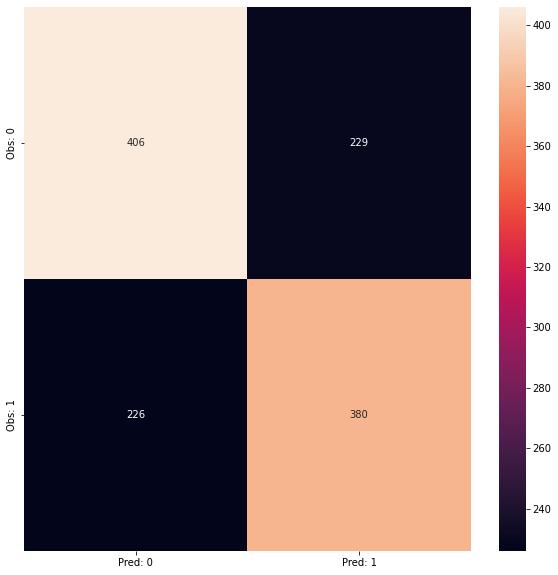

Sensitivity:  0.6270627062706271
Specificity:  0.6393700787401575
Precision:  0.6239737274220033
Accuracy:  0.6333601933924254
63.33601933924255


In [41]:
accuracy = check_accuracy(y_test, y_pred, conf_mat='yes')
print(accuracy*100)
# Accuracy is 84.9% now vs 84.6 earlier.
# Not much difference. 

Sensitivity was extremely Low, when the data was imbalanced.

Now it is very close to Specificity and Precision.

Lowering the threshold from 0.5 to a lower value might increase Sensivity

In [42]:
# from sklearn.preprocessing import Binarizer
# for i in range(1,6):
#     y_pred_yes = logreg.predict_proba(x_test)
#     binarize = Binarizer(threshold=i/10)
#     y_pred2 = binarize.fit_transform(y_pred_yes)[:,1]

#     print(i/10)
#     cm_mat = confusion_matrix(y_test, y_pred2)
#     cm_data(cm_mat)

# 0.2 Threshlod looks good.

In [43]:
# Using Grid Search CV to find best parameters.

params = {
    'penalty': ['l1', 'l2','elasticnet'],
    'tol': [0.1, 0.01],
    'C': [0.1, 0.01],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [10, 100],
    'multi_class': ['auto', 'ovr','multinomial'],
    'n_jobs': [3,4],
}

grid_log_reg = GridSearchCV(LogisticRegression(), params, cv=5, n_jobs=3)
grid_log_reg.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=3,
             param_grid={'C': [0.1, 0.01], 'max_iter': [10, 100],
                         'multi_class': ['auto', 'ovr', 'multinomial'],
                         'n_jobs': [3, 4],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga'],
                         'tol': [0.1, 0.01]})

In [44]:
best_par = grid_log_reg.best_params_
best_par

{'C': 0.1,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': 3,
 'penalty': 'l2',
 'solver': 'newton-cg',
 'tol': 0.1}

In [45]:
best_estimator = grid_log_reg.best_estimator_
best_estimator

LogisticRegression(C=0.1, n_jobs=3, solver='newton-cg', tol=0.1)

In [46]:
best_log_reg_score = cross_val_score(best_estimator, x_train, y_train, cv = 5)
print(best_log_reg_score.mean()*100)

67.96998343241401


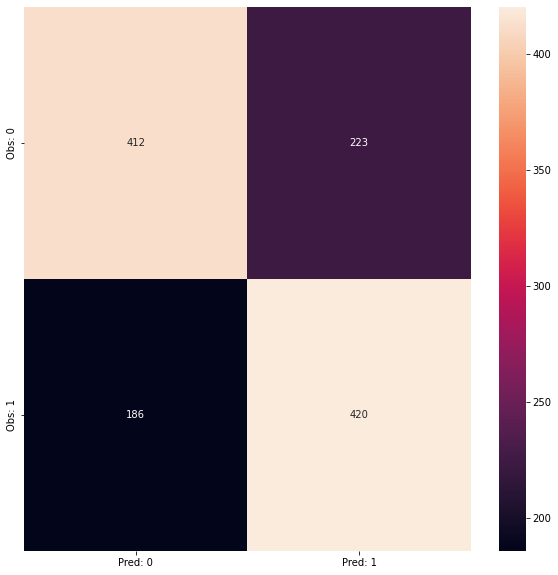

Sensitivity:  0.693069306930693
Specificity:  0.6488188976377953
Precision:  0.6531881804043546
Accuracy:  0.6704270749395649


In [47]:
y_pred_grid = grid_log_reg.predict(x_test)
acc_lg = check_accuracy(y_test, y_pred_grid, conf_mat = 'yes')
# print(acc_lg)
# Accuracy has risen a little bit, but the data still needs to be balanced.

The Accuracy is very low, So lets try other models.

##### 2: Decision Tree Classifier

In [48]:
new_df.TenYearCHD = new_df.TenYearCHD.astype('category')
new_df.TenYearCHD.dtype

CategoricalDtype(categories=[0, 1], ordered=False)

In [49]:
# Using DataFrame new_df
x_train_dt, x_test_dt, y_train_dt, y_test_dt = split_data(new_df)

In [50]:
params_dt = {
    'criterion': ['gini','entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [3, 6, 9],
    'min_samples_leaf': [5, 8, 11],
    'max_features': ['sqrt', 'log2'],
}

grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid=params_dt, n_jobs=4)
grid_dt.fit(x_train_dt, y_train_dt)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 6, 9],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [5, 8, 11],
                         'splitter': ['best', 'random']})

In [51]:
best_estimator_dt = grid_dt.best_estimator_
best_estimator_dt

DecisionTreeClassifier(criterion='entropy', max_depth=9, max_features='sqrt',
                       min_samples_leaf=11)

In [52]:
best_params_dt = grid_dt.best_params_
best_params_dt

{'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_leaf': 11,
 'splitter': 'best'}

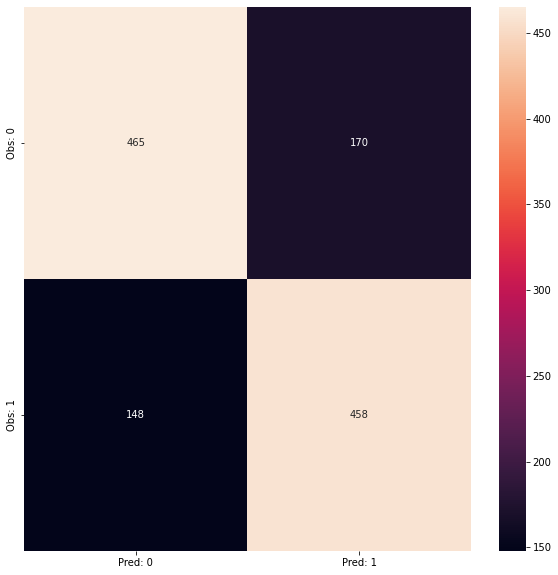

Sensitivity:  0.7557755775577558
Specificity:  0.7322834645669292
Precision:  0.7292993630573248
Accuracy:  0.7437550362610797


In [53]:
pred_dt = grid_dt.predict(x_test_dt)
acc_dt = check_accuracy(y_test_dt, pred_dt, 'yes')

##### 3: KNN Classification

##### 4: SVM

##### 5: Neural Networks

##### 6: Complex SVM

##### 7: Complex Neural Networks 

##### 8: Random Forest Classifier

In [55]:
# def RFmodel(df, tar = target_var, submission = 'No', want_acc = 'No', feat_imp = 'No'):

#     pred_null, accuracy = 0, 0

#     x_train, x_test, y_train, y_test = split_data(df)
#     X_train = x_train[:]

#     x_train = sc.fit_transform(x_train)
#     x_test = sc.transform(x_test)

#     if df[tar].dtype in ['float', 'int']:
#         model = rfr.fit(x_train, y_train)
#         if feat_imp == 'yes':
#             features = rfr.feature_importances_
#             sorted_indices = np.argsort(features)[::-1]
#             plt.title('Feature Importance')
#             plt.bar(range(X_train.shape[1]), features[sorted_indices], align='center')
#             plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
#             plt.tight_layout()
#             plt.show()

#     elif df[tar].dtype == 'category':
#         model = rfc.fit(x_train, y_train)
#         if feat_imp == 'yes':
#             features = rfc.feature_importances_
#             sorted_indices = np.argsort(features)[::-1]
#             plt.title('Feature Importance')
#             plt.bar(range(X_train.shape[1]), features[sorted_indices], align='center')
#             plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
#             plt.tight_layout()
#             plt.show()
#     else:
#         print("No Model")

#     if (want_acc == 'yes') & (df[tar].dtype in ['int', 'float']):
#         accuracy = get_acc(model, x_test, y_test, df[tar].dtype)

#     pred_null = model.predict(x_test)

#     if want_acc == 'yes':
#         accuracy = check_accuracy(y_test, pred_null, conf_mat='yes')


#     return pred_null, accuracy

In [56]:
# Using DataFrame new_df
x_train_rf, x_test_rf, y_train_rf, y_test_rf = split_data(new_df)

In [57]:
x_train_rf = sc.fit_transform(x_train_rf)
x_test_rf = sc.transform(x_test_rf)

Using GridSearchCV for Random Forest Classifier

In [58]:
rf_params = {
    'n_estimators': [10, 50, 100, 150, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [10, 15, 20, 25, 40],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'oob_score': [True],
    'n_jobs': [3],
}

grid_rf = GridSearchCV(RandomForestClassifier(), param_grid=rf_params, cv = 5, n_jobs = 4)
grid_rf.fit(x_train_rf, y_train_rf)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [10, 15, 20, 25, 40],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 50, 100, 150, 200], 'n_jobs': [3],
                         'oob_score': [True]})

In [59]:
best_par_rf = grid_rf.best_params_
best_par_rf

{'bootstrap': True,
 'criterion': 'log_loss',
 'max_depth': 40,
 'max_features': 'log2',
 'n_estimators': 100,
 'n_jobs': 3,
 'oob_score': True}

In [60]:
best_estimator_rf = grid_rf.best_estimator_
best_estimator_rf

RandomForestClassifier(criterion='log_loss', max_depth=40, max_features='log2',
                       n_jobs=3, oob_score=True)

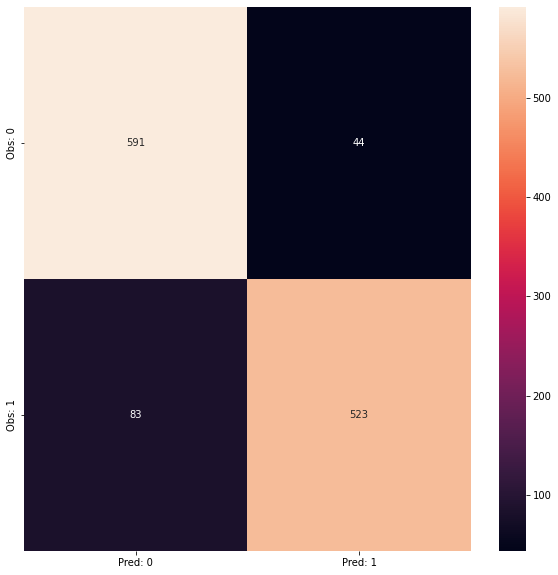

Sensitivity:  0.863036303630363
Specificity:  0.9307086614173228
Precision:  0.9223985890652557
Accuracy:  0.8976631748589847


In [61]:
pred_rf = grid_rf.predict(x_test_rf)
acc_rf = check_accuracy(y_test_rf, pred_rf, 'yes')

In [62]:
# pred, accuracy = RFmodel(new_df, want_acc='yes', feat_imp='yes')

##### 9: Boosting